In [3]:
import pandas as pd  
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
pw2014_ini=pd.read_csv('homeF_2014_merge_2.csv')
pw2015_ini=pd.read_csv('homeF_2015_merge_2.csv')

In [5]:
power = pd.concat([pw2014_ini,pw2015_ini],axis=0,ignore_index=True)

In [7]:
power.head()

,Date & Time,Usage [kW],Generation [kW],WaterHeater [kW],Solar [kW],Refrigerator [kW],Microwave [kW],Furnace [kW],WaterHeater3 [kW],WaterHeater2 [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,2014-01-01 00:00:00,0.977402,0.009264,0.296840,0.009264,0.059256,0.002800,0.008474,0.000531,0.020002,...,10.0,Clear,8.33,1023.40,12.83,0.0,284.0,0.0,3.36,0.0
1,2014-01-01 00:15:00,0.377746,0.009904,0.063231,0.009904,0.003734,0.002914,0.008633,0.000471,0.009642,...,10.0,Clear,8.33,1023.40,12.83,0.0,284.0,0.0,3.36,0.0
2,2014-01-01 00:30:00,0.420196,0.010133,0.001511,0.010133,0.121228,0.002630,0.008059,0.000044,0.000011,...,10.0,Clear,8.33,1023.40,12.83,0.0,284.0,0.0,3.36,0.0
3,2014-01-01 00:45:00,0.290328,0.010029,0.000058,0.010029,0.016986,0.002910,0.008511,0.000411,0.000202,...,10.0,Clear,8.33,1023.40,12.83,0.0,284.0,0.0,3.36,0.0
4,2014-01-01 01:00:00,0.307616,0.010038,0.000127,0.010038,0.014140,0.002691,0.008500,0.000400,0.000200,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0


In [8]:
power.columns

Index(['Date & Time', 'Usage [kW]', 'Generation [kW]', 'WaterHeater [kW]',
       'Solar [kW]', 'Refrigerator [kW]', 'Microwave [kW]', 'Furnace [kW]',
       'WaterHeater3 [kW]', 'WaterHeater2 [kW]', 'WaterHeater1 [kW]',
       'Master_Bdrm [kW]', 'Front_Bdrm [kW]', 'Kit_StoveWall [kW]',
       'Dishwasher_Disposal [kW]', 'Kit_SinkWall [kW]', 'Family_Rm [kW]',
       'Kit_Half-Bath_Foyer [kW]', 'Washing_Machine [kW]',
       'Guest_Bdrm_SmkDet [kW]', 'Dryer [kW]', 'Basement [kW]', 'Phase_B [kW]',
       'Phase_A [kW]', 'year', 'mon', 'day', 'hr', 'min', 'weekday',
       'is_holiday', 'time', 'temperature', 'icon', 'humidity', 'visibility',
       'summary', 'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover',
       'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability'],
      dtype='object')

In [9]:
#descriptive statistics summary
target='Usage [kW]'
power[target].describe()

count    70080.000000
mean         1.315627
std          1.459243
min          0.000000
25%          0.438579
50%          0.815740
75%          1.284938
max         20.819441
Name: Usage [kW], dtype: float64

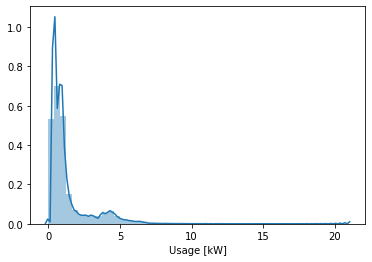

In [10]:
#histogram
sns.distplot(power[target]);

In [11]:
#skewness and kurtosis
print("Skewness: %f" % power[target].skew())
print("Kurtosis: %f" % power[target].kurt())

Skewness: 2.556278
Kurtosis: 8.979878


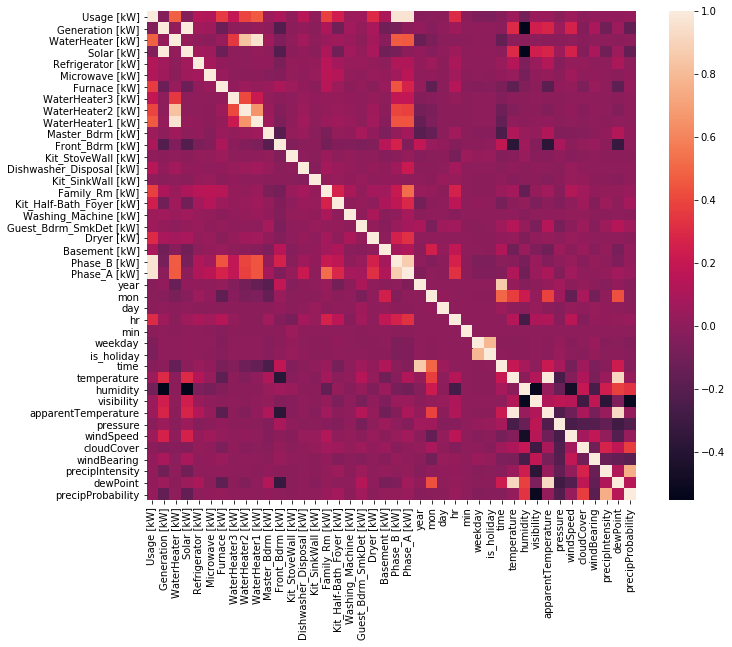

In [12]:
#correlation matrix
corrmat = power.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, square=True);

In [13]:
#Usage[kW] correlation matrix
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, target)[target].index
cm = power[cols].corr()

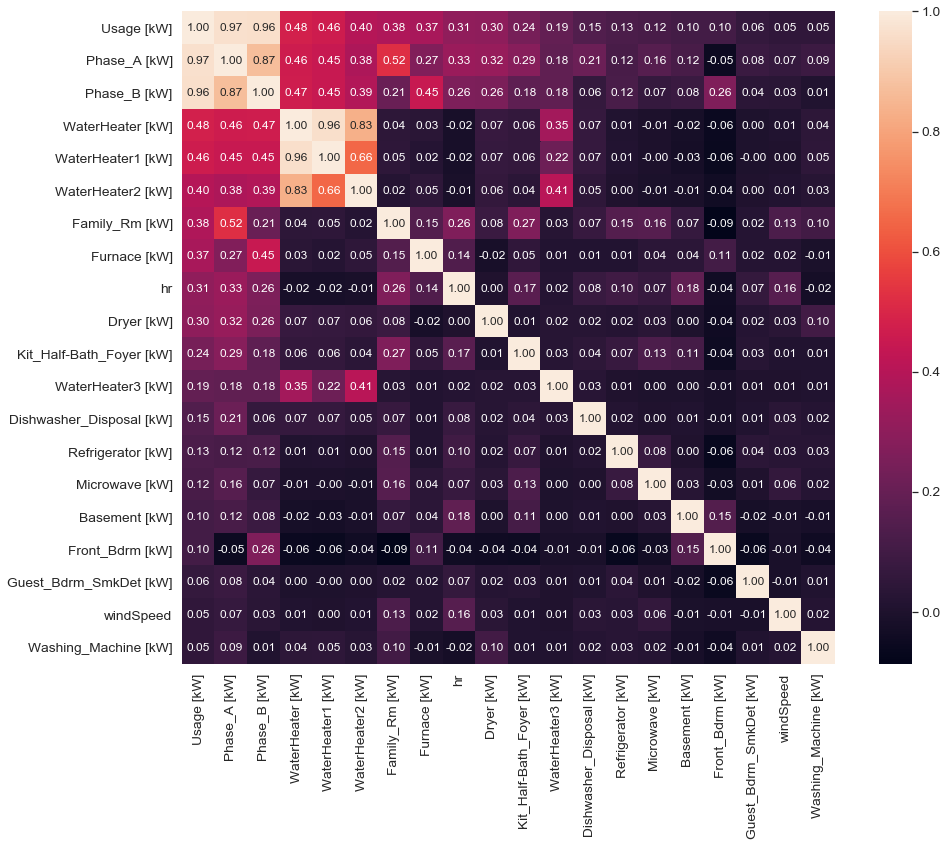

In [14]:
##Usage[kW] correlation matrix
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(16,12 ))
hm = sns.heatmap(cm,vmax=1, cbar=True, annot=True, square=True,linewidths=0, fmt='.2f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [15]:
#由上圖可知 與 Usage[kW]最大關聯的兩個參數為 Phase_A,Phase_b

#檢查缺失值
power.isnull().any()


Date & Time                  True
Usage [kW]                   True
Generation [kW]              True
WaterHeater [kW]             True
Solar [kW]                   True
Refrigerator [kW]            True
Microwave [kW]               True
Furnace [kW]                 True
WaterHeater3 [kW]            True
WaterHeater2 [kW]            True
WaterHeater1 [kW]            True
Master_Bdrm [kW]             True
Front_Bdrm [kW]              True
Kit_StoveWall [kW]           True
Dishwasher_Disposal [kW]     True
Kit_SinkWall [kW]            True
Family_Rm [kW]               True
Kit_Half-Bath_Foyer [kW]     True
Washing_Machine [kW]         True
Guest_Bdrm_SmkDet [kW]       True
Dryer [kW]                   True
Basement [kW]                True
Phase_B [kW]                 True
Phase_A [kW]                 True
year                         True
mon                          True
day                          True
hr                           True
min                          True
weekday       

In [16]:
#移除缺失值
power = power.fillna(method='ffill')

In [18]:
#將資料分成屬性及標籤

X = power[['time','temperature','hr',]] #以時間,溫度,小時為特徵來預測用電量
Y = power['Usage [kW]']

In [19]:
#建立訓練集和測試集

#2014年1月~2015年8月為訓練集,2015年9月~2015年12月為測試集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.167,shuffle=False)
#print('X_train: \n',X_train)
#print('X_test: \n',X_test)
#print('Y_train: \n',Y_train)
#print('Y_test: \n',Y_test)

In [20]:
#建立並訓練模型

regressor = LinearRegression()  
regressor.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [22]:
#分析趨勢線

a  = regressor.intercept_#截距
b = regressor.coef_#迴歸係數
print("擬合參數:截距",a,",迴歸係數：",b)

擬合參數:截距 2.8953360877792127 ,迴歸係數： [-1.68171624e-09  1.73982237e-03  6.40925110e-02]


In [23]:
#顯示線性方程，並限制參數的小數位爲兩位

print("最佳擬合線: Y = ",round(a,2),"+",round(b[0],2),"* X1 + ",round(b[1],2),"* X2",round(b[2],2),"* X3")

最佳擬合線: Y =  2.9 + -0.0 * X1 +  0.0 * X2 0.06 * X3


In [24]:
Y_pred=regressor.predict(X_test)
df = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_pred})
df1 = df.head(25) #顯示實際值和預測值
df

,Actual,Predicted
58378,0.352773,0.774770
58379,0.377611,0.774769
58380,0.372797,0.774767
58381,0.347854,0.836336
58382,0.422536,0.836334
...,...,...
70077,1.159709,1.992101
70078,1.025637,1.992100
70079,1.010514,1.992098
70080,0.928931,1.992097


 
#視覺化


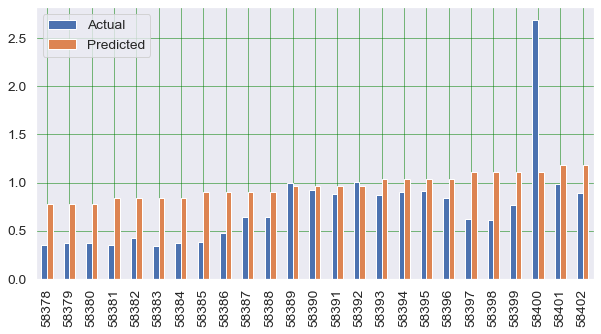

In [25]:
print(' ')
print('#視覺化')
df1.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [26]:
#平均絕對誤差(MAE)、均方誤差(MSE)、均方根誤差(RMSE)
print('*Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
print(' ')  
print('檢查準確度(%): ',regressor.score(X_train, Y_train)*100)

*Mean Absolute Error: 0.8158483629736384
Mean Squared Error: 1.4262517632480534
Root Mean Squared Error: 1.1942578294690194
 
檢查準確度(%):  9.086771138739003


In [27]:
#假設為2015年12月31號23:45分的下一個小時=2016年1月1號00:45分,溫度為20度
data = {'time':[1451624400],
       'temperature':[20],'hr':[0]}
next_hours_data = pd.DataFrame(data)
next_hours_data


,time,temperature,hr
0,1451624400,20,0


In [28]:
#預測下一個小時用電量
next_hours=regressor.predict(next_hours_data)
print('下一小時的電量: ',next_hours)


下一小時的電量:  [0.48891221]


In [ ]:
#假設有未來的時間,溫度,小時之dataset,此dataset之輸出結果為我們的目標

pw2016=pd.read_csv('xxx')#xxx為檔案路徑名稱

In [ ]:
#以時間,溫度,小時為特徵來預測用電量
Z = power2016[['time','temperature','hr',]]
Z_pred=regressor.predict(Z)#預測結果
df = pd.DataFrame({ 'Predicted': Z_pred})
df1 = df.head(25) 
df